# Config and Imports

In [1]:
import os
os.chdir('../../')
prj_path = "./data/IGs/"
print(os.getcwd())

c:\Users\andri\Progetti\igraph_transformer


In [2]:
import random

import os
import torch
import pickle
import torch.utils.data
import time

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from data.IGs import IGsDatasetDGL, IGsDataset

Using backend: pytorch


# Prepare dataset

txt --> train/test/val PKL: NO DGL

In [23]:
def track_list_to_adjacency_matrix(track_list):
    # Determine the maximum number of nodes in the track
    # num_nodes = max(track_list) + 1
    num_nodes = 16

    # Create an empty adjacency matrix
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    # Add connections to the adjacency matrix
    for i in range(len(track_list) - 1):
        current_node = track_list[i]
        next_node = track_list[i + 1]
        adjacency_matrix[current_node][next_node] = 1

    return adjacency_matrix


data_list = []
dataset = []

with open(prj_path + 'ig_subgraphs.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove whitespace and newline characters
        values = line.split(']')  # Split the line based on the ']' character
        nums = values[0].strip('[, ')  # Extract the numbers inside the square brackets
        nums = [int(num) for num in nums.split(',')]  # Convert the numbers into a list of integers
        num_after_bracket = int(values[1].strip())  # Extract the number after the square bracket
        data_list.append([nums, num_after_bracket])

random.shuffle(data_list)

for data in data_list:
    obj = {
        'num_node': len(data[0]),
        'node_type': torch.tensor(data[0], dtype=torch.int8),
        'adj' : torch.tensor(track_list_to_adjacency_matrix(data[0]), dtype=torch.int8),
        'target': torch.tensor(data[1])
    }
    dataset.append(obj)

with open(prj_path + 'igraph-GTN.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [24]:
len(dataset)

53447

### Split and Dump train,val,test pkl

In [25]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Subset
#-------------------------------TRAIN-----------------------------
train_p = 0.7  # Train set percentage
num_samples = len(dataset)
train_samples = int(train_p * num_samples)



# # Get the indices of samples belonging to class 15
# class_15_indices = [i for i, target in enumerate(targets) if target == 15]
# print(len(class_15_indices))

# Remove class 15 samples from the dataset
dataset = [data for data in dataset if data['target'] != 15]
targets = [data['target'] for data in dataset]


# Calculate the frequency of each class and get the weights for each class
class_counts = torch.bincount(torch.tensor(targets))
class_weights = torch.true_divide(1.0, class_counts)

# Normalize the class weights
# class_weights /= torch.max(class_weights)

# Create a tensor of class labels
targets = torch.tensor(torch.tensor(targets))


# WeightedRandomSampler for weight based sampling with replacement
sampler = WeightedRandomSampler(class_weights[targets], train_samples, replacement=False)

train_indices = list(sampler)

# Use the sampler to sample the dataset for the trainset
train = torch.utils.data.Subset(dataset, train_indices)

#-------------------------------TEST/VAL-----------------------------
# Create a subset of the dataset excluding the train indices
remaining_indices = list(set(range(len(dataset))) - set(train_indices))

test_p = 0.6 # % of the remaining samples (note! replacement was used)
test_size = int(test_p*len(remaining_indices))
test_indices = random.sample(remaining_indices, test_size)

# Create the test set with the sampled indices
test = Subset(dataset, test_indices)

# Create a subset of the dataset excluding the train and test indices
val_indices = list(set(range(len(dataset))) - set(train_indices) - set(test_indices))

# Create the test set with the sampled indices
val = Subset(dataset, val_indices)


# # Get the indices of samples belonging to class 15 in the train set
# class_15_indices = [i for i, target in enumerate(targets[train_indices]) if target == 15]

# # Remove class 15 indices from the train indices
# train_indices = list(set(train_indices) - set(class_15_indices))
# train = torch.utils.data.Subset(train, train_indices)

# # Add class 15 indices to the test indices
# test_indices += class_15_indices



print(len(train), len(test), len(val))

37412 9538 6360


c:\Users\andri\miniconda3\envs\graph_transformer\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Total samples in dataset: 37412
class 10: 4313 samples
class 9: 2736 samples
class 2: 3179 samples
class 14: 1902 samples
class 11: 3322 samples
class 5: 3034 samples
class 4: 2505 samples
class 7: 3899 samples
class 13: 2713 samples
class 8: 1327 samples
class 6: 4276 samples
class 12: 1660 samples
class 3: 2546 samples


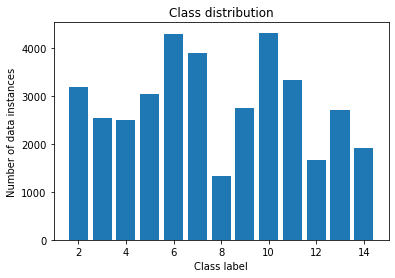

In [26]:
import matplotlib.pyplot as plt
from collections import defaultdict

plt_ds = train

print(f"Total samples in dataset: {len(plt_ds)}")
# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(plt_ds):
    label = data['target']
    class_counts[label.item()] += 1

for key, value in class_counts.items():
    print(f"class {key}: {value} samples")

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title(f'Class distribution')
plt.show()


In [9]:
import statistics
statistics.mean(class_counts.values())

4100.7692307692305

In [28]:
from torch.utils.data import Subset
from collections import defaultdict
# Create dictionary to keep track of indices for each class label
indices = defaultdict(list)
for i, data in enumerate(dataset):
    label = data['target']
    indices[label.item()].append(i)
    
p = 0 # Dataset train percentage to use (test: p/2, val: p/4, total: p + p/2 + p/4)
train_p = 0.80
test_p = 0.10


# TRAIN------------------------------------------------------------------------
# Sample balanced subset of indices from each class for train set
train_indices = []
for label_indices in indices.values():
  
    num_samples = len(label_indices)
    
    if p == 0:
      num_train_samples = int(train_p * num_samples) 
    else:
      num_train_samples = int(p * num_samples)
    
    train_indices += random.sample(label_indices, num_train_samples)
    random.shuffle(train_indices)
    
train = Subset(dataset, train_indices)
# train = [dataset[i] for i in train_indices[0:100]]

# Sample balanced subset of indices from each class for test set
test_indices = []


# TEST-------------------------------------------------------------------------
for label_indices in indices.values():
  
    num_samples = len(label_indices)
    label_indices = set(label_indices) - set(train_indices)  # Remove train indices from consideration

    if p == 0:
      num_test_samples = int(test_p * num_samples)
    else:
      num_test_samples = int((p/2) * num_samples)
    
    test_indices += random.sample(label_indices, num_test_samples)
    random.shuffle(test_indices)
    
test = Subset(dataset, test_indices)

# test = [dataset[i] for i in test_indices[0:100]]

# VALIDATION-------------------------------------------------------------------
# Sample balanced subset of indices from each class for val set
val_indices = []

for label_indices in indices.values():
  
    num_samples = len(label_indices)
    label_indices = set(label_indices) - set(train_indices) - set(test_indices)  # Remove train and validation indices from consideration
    
    if p == 0:
      val_indices += label_indices
    else:
      num_val_samples = int((p/4) * num_samples)
      val_indices += random.sample(label_indices, num_val_samples)
    
    random.shuffle(val_indices)
    
val = Subset(dataset, val_indices)

In [32]:

# val = [dataset[i] for i in val_indices[0:100]] 

print(f"Size of train set is {len(train)}")
print(f"Size of test set is {len(test)}")
print(f"Size of val set is {len(val)}")
#train, test_val_data = train_test_split(dataset, test_size=0.3, random_state=42)
#test, val = train_test_split(test_val_data, test_size=0.7, random_state=42)


start = time.time()
with open(prj_path + 'igraph-GTN-train.pkl','wb') as f:
        pickle.dump(train, f)
with open(prj_path + 'igraph-GTN-test.pkl','wb') as f:
        pickle.dump(test, f)
with open(prj_path + 'igraph-GTN-val.pkl','wb') as f:
        pickle.dump(val, f)

print('Time (sec):',time.time() - start)

Size of train set is 37317
Size of test set is 9595
Size of val set is 6398
Time (sec): 22.32320761680603


# Load Dataset

In [33]:
if not os.path.isfile(prj_path + 'igraph-DatasetDGL.pkl'):
  # file presente --> pkl load
  # with open(prj_path + 'igraph-DatasetDGL.pkl', "rb") as f:
  #   f = pickle.load(f)
  #   datasetDGL = f
  datasetDGL = IGsDataset()
else:
  # dataset non presente -> generazione
  datasetDGL = IGsDatasetDGL()

  start = time.time()
  with open(prj_path + 'igraph-DatasetDGL.pkl', 'wb') as f:
          #pickle.dump([datasetDGL.train,datasetDGL.val,datasetDGL.test], f)
          pickle.dump(datasetDGL, f)
  print('Time (sec):',time.time() - start)

[I] Loading data ...
preparing 37317 graphs for the TRAIN set...
preparing 6398 graphs for the VAL set...
preparing 9595 graphs for the TEST set...
[I] Finished loading.
Time taken: 297.1800s
Time (sec): 48.51616287231445


In [34]:
max_num_nodes = 0
for graph, _ in datasetDGL.train:
    num_nodes = graph.number_of_nodes()
    if num_nodes > max_num_nodes:
        max_num_nodes = num_nodes
print(f"Max graph size is: {max_num_nodes}")

Max graph size is: 26


In [5]:
datasetDGL.train[1][0]

Graph(num_nodes=7, num_edges=6,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})

### Explore dataset

In [17]:
print(len(datasetDGL.train))
print(len(datasetDGL.val))
print(len(datasetDGL.test))

print(datasetDGL.train[0])
print(datasetDGL.val[0])
print(datasetDGL.test[0])

43366
10853
18066
(Graph(num_nodes=11, num_edges=8,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(7))
(Graph(num_nodes=16, num_edges=10,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(12))
(Graph(num_nodes=14, num_edges=5,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(6))


Total samples in dataset: 72285
class 4: 3643 samples
class 13: 3577 samples
class 8: 3674 samples
class 7: 3634 samples
class 12: 3587 samples
class 2: 3617 samples
class 6: 3536 samples
class 9: 3489 samples
class 10: 3646 samples
class 15: 3514 samples
class 14: 3602 samples
class 11: 3699 samples
class 5: 3720 samples
class 3: 3661 samples


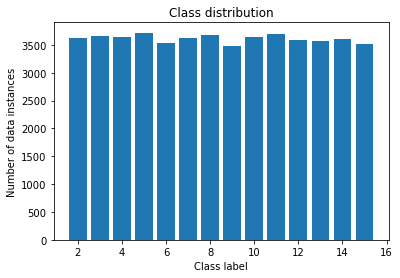

In [68]:
import matplotlib.pyplot as plt
from collections import defaultdict
print(f"Total samples in dataset: {len(dataset)}")
plt_ds = train
# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(plt_ds):
    label = data['target']
    class_counts[label.item()] += 1

for key, value in class_counts.items():
    print(f"class {key}: {value} samples")

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title(f'Class distribution')
plt.show()


In [7]:
# Create set of unique classes in train set
unique_classes = set()
for data in train:
    label = data['target']
    unique_classes.add(label.item())

# Count number of unique classes
num_classes = len(unique_classes)
print("Number of unique classes in train set: ", num_classes)
print(unique_classes)

NameError: name 'train' is not defined

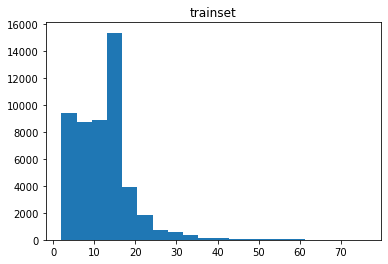

min/max : 2 76


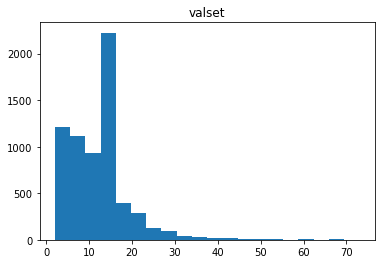

min/max : 2 73


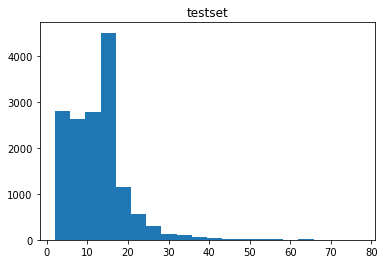

min/max : 2 77


In [8]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())

plot_histo_graphs(datasetDGL.train,'trainset')
plot_histo_graphs(datasetDGL.val,'valset')
plot_histo_graphs(datasetDGL.test,'testset')

# Test

In [50]:
train[0]

{'num_node': 14,
 'node_type': tensor([0, 1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=torch.int8),
 'adj': tensor([[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]], dtype=torch.int8),
 'target': tensor(6)}

In [68]:
datasetDGL.train[0][1].item()


6